In [12]:
import numpy as np
from scipy.special import binom # calculates binomial coefficient
from scipy import stats
from matplotlib import pyplot as plt

In [5]:
from functools import lru_cache

## Тест на честность монетки.


Давайте попробуем написать тест на чесность монетки. Пусть нам известно, что монетку бросили $n$ раз и из них
$k$ раз монетка выпала орлом. В качестве статистики нечестности монетки будем использовать модуль отклонения получившегося k от ожидаемого в случае если монетка честая ($n/2$).

In [6]:
def two_tailed_deviation(n_tosses, n_heads):
    return abs(n_tosses / 2 - n_heads)

@lru_cache(None)
def calc_pvalue(n_tosses, n_heads, calc_deviation):
    deviation = calc_deviation(n_tosses, n_heads)
    pvalue = 0.0
    for possible_heads_count in range(n_tosses + 1):
        if calc_deviation(n_tosses, possible_heads_count) >= deviation:
            pvalue += binom(n_tosses, possible_heads_count) * (1 / 2) ** n_tosses
    return pvalue

Проверим правильно ли мы все посчитали. Зафиксируем уровень значимости. Просимулируем

In [26]:
def simulate_tosses(n_tosses, p_head=0.5, significance_level=0.05,
                   calc_deviation=two_tailed_deviation,
                   n_simulations=10000):
    head_counts = np.random.binomial(n_tosses, p_head, n_simulations)
    positive_results = 0
    for n_heads in head_counts:
        if calc_pvalue(n_tosses, n_heads, calc_deviation) < significance_level:
            positive_results += 1
    return positive_results

def plot_stat_distr(n_tosses, significance_level=0.05,
                    calc_deviation=two_tailed_deviation):
    val_to_prob = {}
    distr = stats.binom(n_tosses, 0.5)
    for n_heads in range(n_tosses + 1):
        stat_value = calc_deviation(n_tosses, n_heads)
        val_to_prob[stat_value] = val_to_prob.get(stat_value, 0) + distr.pmf(n_heads)
    items = sorted(val_to_prob.items())
    sorted_values = [val for val, prob in items]
    probs = [prob for val, prob in items]
    
    cum_prob = 0
    threshold_index = None
    for i, prob in reversed(list(enumerate(probs))):
        if cum_prob > significance_level:
            break
        cum_prob += prob
        threshold_index = i
    
    threshold = (sorted_values[threshold_index] +
                 sorted_values[threshold_index + 1]) / 2
    overshoot_threshold = (
        sorted_values[threshold_index] +
        sorted_values[threshold_index - 1]) / 2
    real_significance_level = cum_prob - probs[threshold_index]
    plt.rc("figure", figsize=(16, 10))
    plt.bar(sorted_values, probs)
    plt.vlines(
        threshold, 0, max(probs),
        label="Порог {:.3}".format(real_significance_level),
        color="red"
    )
    plt.vlines(
        overshoot_threshold, 0, max(probs),
        label="Порог {:.3}".format(cum_prob),
        color="grey"
    )
    plt.legend()
    plt.show()

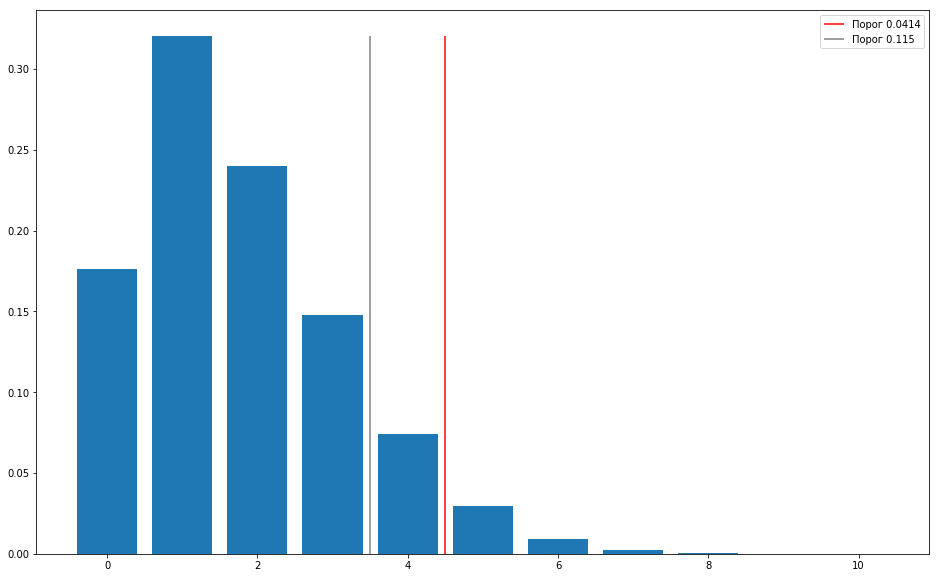

Симулируем броски честной монетки:
395 / 10000 раз мы заподозрили монетку в нечестности.


In [40]:
n_tosses = 20
n_simulations = 10000

plot_stat_distr(n_tosses)

print("Симулируем броски честной монетки:")
positive_results = simulate_tosses(n_tosses, n_simulations=n_simulations)
print("{} / {} раз мы заподозрили монетку в нечестности.".format(positive_results, n_simulations))

**Задача 1.1*:**

а)* Почему доля положительных результатов нашего теста (в среднем) получается меньше заданного нами уровня значимости? (эффект особенно силен при небольшом количестве игр)

б) Чему равна точная вероятность ложно-положительного результата? (напишите формулу или код, который считает эту вероятность). 

In [66]:
p_head = 0.4
print("А теперь представим, что вероятность орла {}:".format(p_head))
n_shootouts = simulate_tosses(n_tosses, p_head=p_head, significance_level=0.12)
print("{} / {} раз мы заподозрили монетку в нечестности.".format(n_shootouts, n_simulations))


А теперь представим, что вероятность орла 0.4:
2602 / 10000 раз мы заподозрили монетку в нечестности.


Как видно, если монетка нечестная, мы далеко не всегда можем с уверенностью установить это, если число бросков недостаточно велико. 

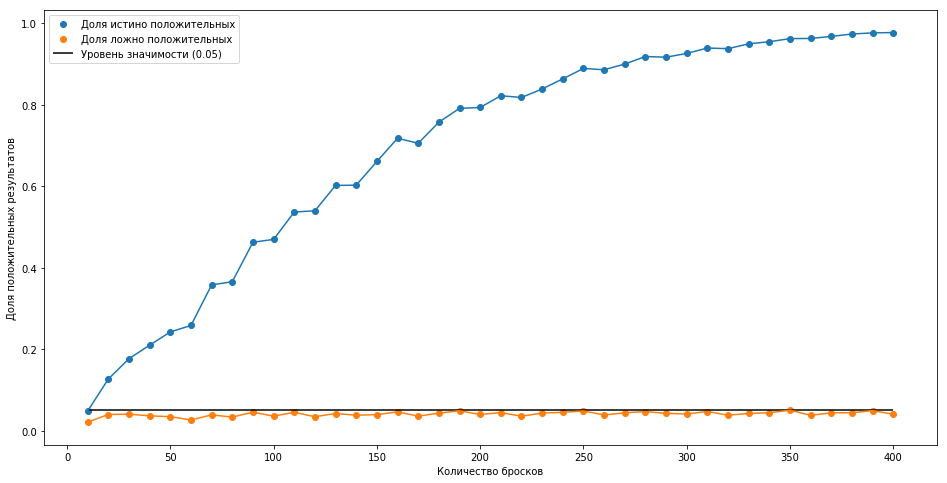

In [67]:
n_tosses_variants = [i for i in range(10, 401, 10)]
n_simulations = 10000

true_positives_counts = [simulate_tosses(n, p_head, n_simulations=n_simulations) / n_simulations
                  for n in n_tosses_variants]
false_positives_counts = [simulate_tosses(n, p_head=0.5, n_simulations=n_simulations) / n_simulations
                   for n in n_tosses_variants]

plt.rc("figure", figsize=(16, 8))
plt.plot(n_tosses_variants, true_positives_counts)
plt.scatter(n_tosses_variants, true_positives_counts, label='Доля истино положительных')
plt.plot(n_tosses_variants, false_positives_counts)
plt.scatter(n_tosses_variants, false_positives_counts, label='Доля ложно положительных')
plt.hlines(0.05, min(n_tosses_variants), max(n_tosses_variants), label="Уровень значимости (0.05)")
plt.xlabel("Количество бросков")
plt.ylabel("Доля положительных результатов")
plt.legend()
plt.show()

А теперь заставим тест пытаться детектировать не случаи когда монетка нечестная, а только те, когда она нечестная в меньшую сторону (как если бы мы играли в орлянку ставя на орла и были бы очень обеспокоены, если бы кто-то нас обманывал с помощью нечестной монетки) 

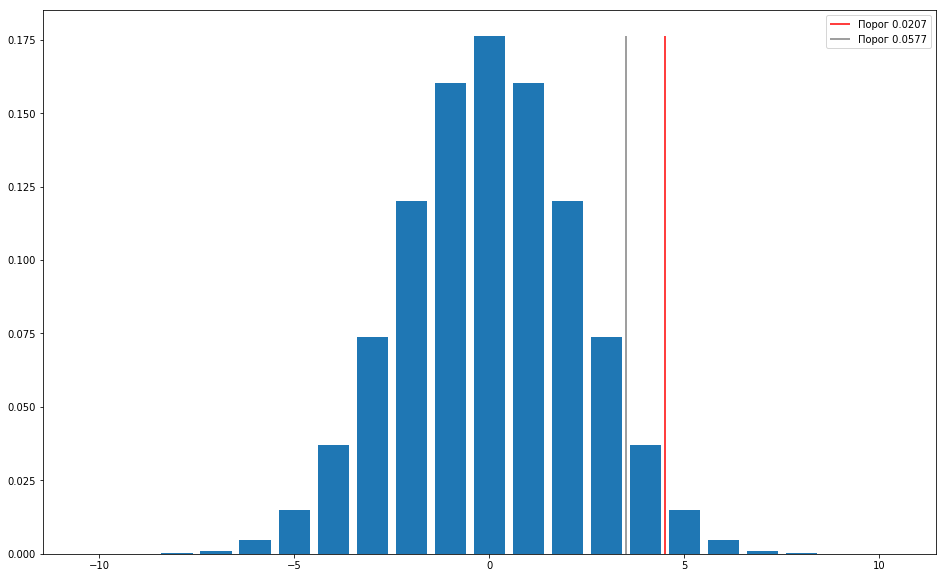

In [68]:
def one_tailed_deviation(n_tosses, n_heads):
    return n_tosses / 2 - n_heads

plot_stat_distr(20, calc_deviation=one_tailed_deviation)


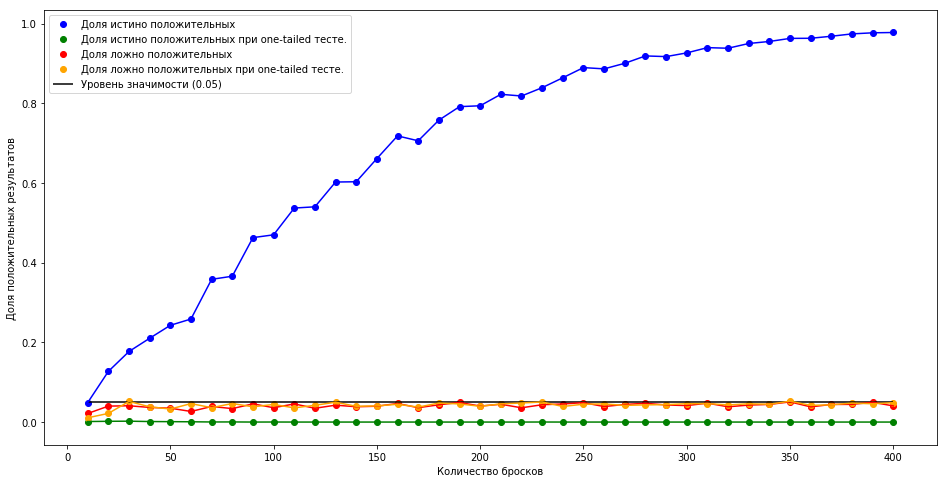

In [69]:
n_tosses_variants = [i for i in range(10, 401, 10)]
n_simulations = 10000
p_head = 0.6

true_one_tailed_positives_counts = [
    simulate_tosses(n, p_head, n_simulations=n_simulations,
                   calc_deviation=one_tailed_deviation) / n_simulations
    for n in n_tosses_variants
]
false_one_tailed_positives_counts = [
    simulate_tosses(n, p_head=0.5, n_simulations=n_simulations,
                   calc_deviation=one_tailed_deviation) / n_simulations
    for n in n_tosses_variants
]

plt.rc("figure", figsize=(16, 8))
plt.plot(n_tosses_variants, true_positives_counts, color="blue")
plt.scatter(n_tosses_variants, true_positives_counts,
            label='Доля истино положительных', color="blue")
plt.plot(n_tosses_variants, true_one_tailed_positives_counts, color="green")
plt.scatter(n_tosses_variants, true_one_tailed_positives_counts,
            label='Доля истино положительных при one-tailed тесте.', color="green")
plt.plot(n_tosses_variants, false_positives_counts, color="red")
plt.scatter(n_tosses_variants, false_positives_counts,
            label='Доля ложно положительных', color="red")
plt.plot(n_tosses_variants, false_one_tailed_positives_counts, color="orange")
plt.scatter(n_tosses_variants, false_one_tailed_positives_counts,
            label='Доля ложно положительных при one-tailed тесте.', color="orange")
plt.hlines(0.05, min(n_tosses_variants), max(n_tosses_variants), label="Уровень значимости (0.05)")
plt.xlabel("Количество бросков")
plt.ylabel("Доля положительных результатов")
plt.legend()
plt.show()